In [1]:
import os
import glob
import pyart
import numpy as np
import xarray as xr
import pandas as pd
import pyscancf as pcf
import cartopy.crs as ccrs
from skimage import measure
import cartopy.feature as feat
from datetime import datetime
import matplotlib.pyplot as plt
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from scipy.ndimage import gaussian_filter, median_filter


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## Cite PyScanCf:

## Syed, H. A.,Sayyed, I., Kalapureddy, M. C. R., & Grandhi, K. K.(2021). 
## PyScanCf – The library for individual sweep datasets of IMD weather radars. 
## Zenodo. doi:10.5281/zenodo.5574160.



In [2]:
import urllib.request
url = "https://raw.githubusercontent.com/syedhamidali/test_scripts/master/map_features.py"
urllib.request.urlretrieve(url, "map_features.py")
import map_features as mf

## Gridded Radar

In [3]:
file = '/Users/syed44/Downloads/Others/Git_Stuff/imd_temp_radar/out/grid_GOA210516024101-IMD-B.nc'

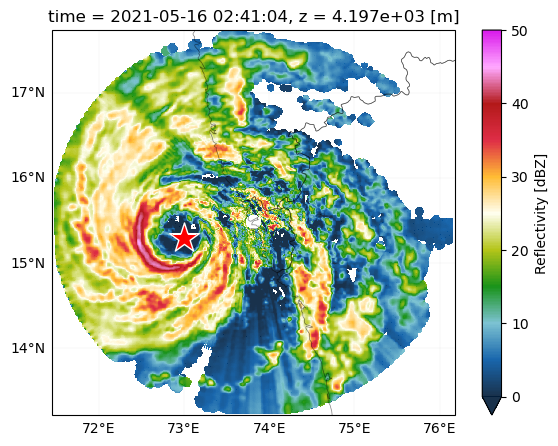

In [4]:
grid = pyart.io.read_grid(file).to_xarray()

grid = grid.where((grid.REF>-20)&(grid.REF<100)).isel(z=8)

fig = plt.figure(figsize=[7, 5])
ax = plt.axes(projection=ccrs.PlateCarree())
grid['REF'].plot(vmin=0, vmax=50, cmap='SyedSpectral',
                 x='lon', y='lat', ax=ax, alpha=0.9)

center_lat = 15.3
center_lon = 73
ax.scatter(center_lon, center_lat, marker='*', s=500,
                    facecolor='r', edgecolor='w')
mf.map_features(ax=ax, b=1, l=1)

In [21]:
def detect_eye(filename, eye_center_lat=15.2, eye_center_lon=73, ref_contour=18):
    """
    Detect the eye of the cyclone around the given lat and lon in imd_ds and fit an
    ellipse to the nearest ref_contour dBZ contour.
    
    Parameters:
    filename (str): Path to the NetCDF file.
    eye_center_lat (float): Latitude of the eye center.
    eye_center_lon (float): Longitude of the eye center.
    ref_contour (float): Reflectivity value to use for contour detection.
    
    Returns:
    xarray.Dataset: Dataset with ellipse parameters and calculated Eye Roundness Value (ERV).
    """
    grid = pyart.io.read_grid(filename).to_xarray()
    grid = grid.where((grid.REF > -20) & (grid.REF < 100)).isel(z=8)

    # fig = plt.figure(figsize=[7, 5])
    # ax = plt.axes(projection=ccrs.PlateCarree())
    # grid['REF'].plot(vmin=0, vmax=50, cmap='Greys_r', x='lon', y='lat', ax=ax, alpha=0.6)

    # ax.scatter(eye_center_lon, eye_center_lat, marker='*', s=500, facecolor='r', edgecolor='w')
    
    # Extract reflectivity data and coordinates
    reflectivity = grid['REF'].isel(time=0).values
    lon = grid['lon'].values
    lat = grid['lat'].values

    # Find the nearest grid point to the given lat and lon
    distance = np.sqrt((lon - eye_center_lon) ** 2 + (lat - eye_center_lat) ** 2)
    nearest_idx = np.unravel_index(np.argmin(distance), distance.shape)

    # Apply median filter for initial noise reduction
    reflectivity = median_filter(reflectivity, size=10)

    # Identify the specified dBZ contour
    contours = measure.find_contours(reflectivity, level=ref_contour)

    # Find the contour closest to the identified eye point
    min_dist = np.inf
    best_contour = None
    for contour in contours:
        dist = np.min(np.sqrt((lon[contour[:, 0].astype(int), contour[:, 1].astype(int)] - eye_center_lon) ** 2 +
                              (lat[contour[:, 0].astype(int), contour[:, 1].astype(int)] - eye_center_lat) ** 2))
        if dist < min_dist:
            min_dist = dist
            best_contour = contour

    # Fit an ellipse to the eye contour using EllipseModel
    ellipse_params = None
    erv = None
    if best_contour is not None:
        # Get the coordinates of the contour
        y, x = best_contour.T
        
        # Fit an ellipse to the coordinates
        ellipse_model = EllipseModel()
        if ellipse_model.estimate(np.column_stack([x, y])):
            xc, yc, a, b, theta = ellipse_model.params

            # Plot the results
            fig, ax = plt.subplots()
            ax.imshow(reflectivity, cmap='Greys', origin='lower')
            ax.plot(x, y, 'b', linewidth=2)

            # Add the fitted ellipse to the plot
            ellipse_patch = Ellipse((xc, yc), 2*a, 2*b, angle=np.degrees(theta), edgecolor='k', facecolor='none', lw=2)
            ax.add_patch(ellipse_patch)
            # plt.scatter(nearest_idx[1], nearest_idx[0], color='yellow', zorder=5)  # Mark the nearest point
            plt.title('Hurricane Eye Detection')
            plt.show()

            # Calculate the eye roundness value (ERV)
            erv = np.sqrt(1 - (b/a)**2)
            print(f"Eye Roundness Value (ERV): {erv}")
            
            ellipse_params = {
                'xc': xc,
                'yc': yc,
                'a': a,
                'b': b,
                'theta': theta,
                'erv': erv
            }
        else:
            print("Ellipse fitting failed.")
    else:
        print("No suitable contour found.")

    # Create an xarray Dataset with the ellipse parameters and ERV
    if ellipse_params:
        ellipse_ds = xr.Dataset(
            {
                'xc': (['time'], [ellipse_params['xc']]),
                'yc': (['time'], [ellipse_params['yc']]),
                'a': (['time'], [ellipse_params['a']]),
                'b': (['time'], [ellipse_params['b']]),
                'theta': (['time'], [ellipse_params['theta']]),
                'erv': (['time'], [ellipse_params['erv']]),
                'contour_x': (['contour'], best_contour[:, 1]),
                'contour_y': (['contour'], best_contour[:, 0]),
                'contour_lon': (['contour'], lon[best_contour[:, 0].astype(int), best_contour[:, 1].astype(int)]),
                'contour_lat': (['contour'], lat[best_contour[:, 0].astype(int), best_contour[:, 1].astype(int)])
            },
            coords={
                'time': grid['time'],
                'contour': np.arange(best_contour.shape[0])
            }
        )
    else:
        ellipse_ds = xr.Dataset(
            {
                'xc': (['time'], [np.nan]),
                'yc': (['time'], [np.nan]),
                'a': (['time'], [np.nan]),
                'b': (['time'], [np.nan]),
                'theta': (['time'], [np.nan]),
                'erv': (['time'], [np.nan]),
                'contour_x': (['contour'], []),
                'contour_y': (['contour'], []),
                'contour_lon': (['contour'], []),
                'contour_lat': (['contour'], [])
            },
            coords={
                'time': grid['time'],
                'contour': []
            }
        )

    return ellipse_ds

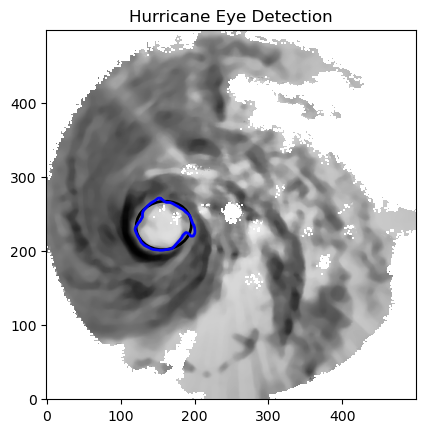

Eye Roundness Value (ERV): 0.49322116965324914


In [22]:
# Example usage
filename = file  # Replace with your file path
ellipse_ds = detect_eye(filename, eye_center_lat=15.2, eye_center_lon=73, ref_contour=18)

In [23]:
ellipse_ds

<xarray.Dataset> Size: 13kB
Dimensions:      (time: 1, contour: 311)
Coordinates:
  * time         (time) object 8B 2021-05-16 02:41:04
    z            float64 8B 4.197e+03
  * contour      (contour) int64 2kB 0 1 2 3 4 5 6 ... 305 306 307 308 309 310
Data variables:
    xc           (time) float64 8B 158.3
    yc           (time) float64 8B 234.6
    a            (time) float64 8B 37.54
    b            (time) float64 8B 32.66
    theta        (time) float64 8B 0.1741
    erv          (time) float64 8B 0.4932
    contour_x    (contour) float64 2kB 154.3 155.0 155.6 ... 153.0 154.0 154.3
    contour_y    (contour) float64 2kB 271.0 270.3 270.0 ... 271.6 271.3 271.0
    contour_lon  (contour) float64 2kB 72.92 72.93 72.93 ... 72.91 72.92 72.92
    contour_lat  (contour) float64 2kB 15.68 15.67 15.67 ... 15.68 15.68 15.68